# **0. Setup**

In [ ]:
# !nvidia-smi -L
# !pip -q install "qdrant-client>=1.8.0" "transformers>=4.44.0" accelerate sentencepiece pillow
# !pip -q install "torchvision"

In [ ]:
N_TEXTS = 10
M_IMGS = 5
K_OBJS = 3

## Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/MLQA-TSR/BERRY

/content/drive/.shortcut-targets-by-id/1vpGlHzFEFiVjezt2LlRLmWJiMX4Drfmp/MLQA-TSR/BERRY


## Qdrant

In [ ]:
!pip install -q qdrant-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.2/377.2 kB 12.3 MB/s eta 0:00:00


In [ ]:
QDRANT_URL = "https://x.cloud.qdrant.io"
QDRANT_API_KEY = "x"
COLLECTION_NAME = "mlqa_tsr_train_v2"

## Data path & sample

In [ ]:
from pathlib import Path
from datetime import datetime
import os

DATA_ROOT = "/content/drive/MyDrive/MLQA-TSR/data"

# ===== TRAIN =====
TRAIN_JSON = f"{DATA_ROOT}/train_data/vlsp_2025_train.json"
TRAIN_IMAGE_DIR = f"{DATA_ROOT}/train_data/train_images"
TRAIN_IMAGE_DIR = Path(TRAIN_IMAGE_DIR)

# ===== PUBLIC TEST =====
TEST_JSON = f"{DATA_ROOT}/public_test/vlsp_2025_public_test_task1.json"
TEST_IMAGE_DIR = f"{DATA_ROOT}/public_test/public_test_images"
TEST_IMAGE_DIR = Path(TEST_IMAGE_DIR)

# ===== OUTPUT =====
OUT_DIR = "/content/drive/MyDrive/MLQA-TSR/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

run_time = datetime.now().strftime("%Y%m%d-fulldata")

# outputs/YYYYMMDD/
RUN_DIR = os.path.join(OUT_DIR, run_time)
os.makedirs(RUN_DIR, exist_ok=True)

print("RUN_DIR:", RUN_DIR)

# SUBTASK 1 - retrieval cache
RETRIEVAL_PATH = os.path.join(RUN_DIR, f"subtask1_retrieval_n{N_TEXTS}_m{M_IMGS}_k{K_OBJS}_v2.pkl")
print("RETRIEVAL_PATH:", RETRIEVAL_PATH)
EVAL_PATH = os.path.join(RUN_DIR, f"subtask1_eval_n{N_TEXTS}_m{M_IMGS}_k{K_OBJS}_v2.txt")
print("EVAL_PATH:", EVAL_PATH)

RUN_DIR: /content/drive/MyDrive/MLQA-TSR/BERRY/outputs/20251225-fulldata
RETRIEVAL_PATH: /content/drive/MyDrive/MLQA-TSR/BERRY/outputs/20251225-fulldata/subtask1_retrieval_n10_m5_k3_v2.pkl
EVAL_PATH: /content/drive/MyDrive/MLQA-TSR/BERRY/outputs/20251225-fulldata/subtask1_eval_n10_m5_k3_v2.txt


### QA

In [ ]:
import json

with open(TRAIN_JSON, "r", encoding="utf-8") as f:
    train_data = json.load(f)

print("Num train samples:", len(train_data))
print("\nKeys of one sample:")
print(train_data[0].keys())

print("\nExample sample (pretty print):")
import pprint
pprint.pprint(train_data[0])


Num train samples: 530

Keys of one sample:
dict_keys(['id', 'image_id', 'question', 'relevant_articles', 'question_type', 'choices', 'answer'])

Example sample (pretty print):
{'answer': 'B',
 'choices': {'A': 'Từ 6:30 đến 8:00 và từ 16:30 đến 18:30; ngoài các khoảng '
                  'thời gian này không được phép lưu thông.',
             'B': 'Từ 6:30 đến 8:00 và từ 16:30 đến 18:30; ngoài các khoảng '
                  'thời gian này được phép lưu thông.',
             'C': 'Cấm lưu thông cả ngày.',
             'D': 'D. Không cấm xe khách trên 29 chỗ lưu thông.'},
 'id': 'train_1',
 'image_id': 'train_1_3',
 'question': 'Biển báo cấm xe khách trên 29 chỗ được áp dụng trong các khoảng '
             'thời gian nào? ',
 'question_type': 'Multiple choice',
 'relevant_articles': [{'article_id': '22', 'law_id': 'QCVN 41:2024/BGTVT'}]}


In [ ]:
import json

with open(TEST_JSON, "r", encoding="utf-8") as f:
    test_data = json.load(f)

print("Num test samples:", len(test_data))
print("\nKeys of one sample:")
print(test_data[0].keys())

print("\nExample sample (pretty print):")
import pprint
pprint.pprint(test_data[0])


Num test samples: 100

Keys of one sample:
dict_keys(['id', 'image_id', 'question', 'relevant_articles', 'question_type', 'choices', 'answer'])

Example sample (pretty print):
{'answer': 'D',
 'choices': {'A': 'Cấm dừng xe và đỗ xe',
             'B': 'Cấm đỗ xe',
             'C': 'Cấm đỗ xe vào ngày lẻ',
             'D': 'Cấm đỗ xe vào ngày chẵn'},
 'id': 'public_test_1',
 'image_id': 'public_test_2_2',
 'question': 'Đây là biển báo gì?',
 'question_type': 'Multiple choice',
 'relevant_articles': [{'article_id': '22', 'law_id': 'QCVN 41:2024/BGTVT'},
                       {'article_id': 'B.31', 'law_id': 'QCVN 41:2024/BGTVT'}]}


### Image

Image path: /content/drive/MyDrive/MLQA-TSR/BERRY/data/train_data/train_images/train_1_3.jpg
Exists: True


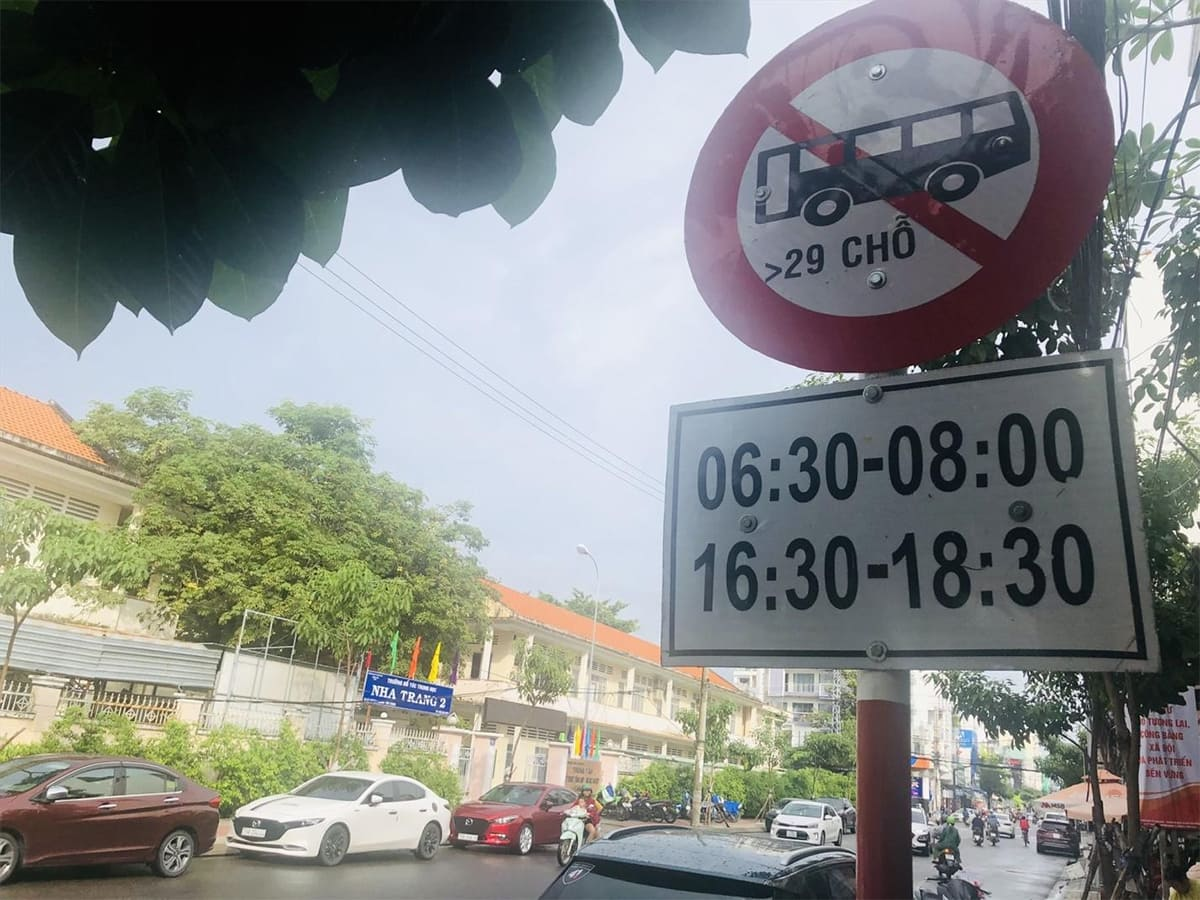

In [ ]:
from PIL import Image
import os

sample = train_data[0]
image_id = sample.get("image_id") or sample.get("image")

img_path = f"{TRAIN_IMAGE_DIR}/{image_id}.jpg"
print("Image path:", img_path)
print("Exists:", os.path.exists(img_path))

img = Image.open(img_path)
img


# Helper/Util

In [ ]:
# 1.1.3
def _ensure_flat_prompts(prompts):
    if len(prompts) == 0:
        return prompts
    if isinstance(prompts[0], list):
        return [p for group in prompts for p in group]
    return prompts

In [ ]:
# 1.1.4
def build_text_input(sample: dict) -> str:
    """
    Paper Berry: text embedding = question + all choices
    Dataset VLSP 2025: choices là dict {A,B,C,D} và cả Y/N
    """
    question = sample["question"]
    choices = sample.get("choices")

    # Multiple choice
    if choices:
        choice_text = " ".join(
            f"{k}. {v}" for k, v in choices.items()
        )
        return f"{question} {choice_text}"

    # Yes/No
    return question


In [ ]:
# 1.1.5
import hashlib
import uuid

def sample_id_to_uuid(sample_id: str) -> str:
    """Convert sample_id string thành UUID deterministic"""
    # Dùng MD5 hash để tạo UUID nhất quán
    hash_bytes = hashlib.md5(sample_id.encode('utf-8')).digest()
    return str(uuid.UUID(bytes=hash_bytes))

def format_choices(choices: dict) -> str:
    """Format choices dict thành string"""
    if not choices:
        return ""
    lines = []
    for k, v in choices.items():
        lines.append(f"{k}. {v}")
    return "\n".join(lines)

In [ ]:
### --- Xóa hết trong qdrant đi!!
# from qdrant_client.models import Filter

# client.delete(
#     collection_name=COLLECTION_NAME,
#     points_selector=Filter()   # filter rỗng = match ALL points
# )

In [ ]:
# 1.2.1.
from qdrant_client.http import models as qmodels

def make_ids_filter(scored_points):
    """Tạo filter để chỉ search trong list IDs cụ thể"""
    ids = [p.id for p in scored_points]
    return qmodels.Filter(
        must=[qmodels.HasIdCondition(has_id=ids)]
    )

In [ ]:
# 1.2.3
def extract_articles_from_results(retrieved_samples, max_articles=None):
    """
    Extract unique articles from top-k retrieved samples

    Args:
        retrieved_samples: List[(Record, score), ...]
        max_articles: Number of TOP SAMPLES to consider (NOT number of articles)

    Returns:
        Set of (law_id, article_id) tuples
    """
    articles = set()

    # Take top-k samples
    for record, score in retrieved_samples[:max_articles]:
        # Extract ALL articles from each sample
        for article in record.payload.get('relevant_articles', []):
            articles.add((article['law_id'], article['article_id']))

    return articles

# **1. Subtask 1 - Retrieval Articles**

## **1.1. Vector Indexing trong paper**

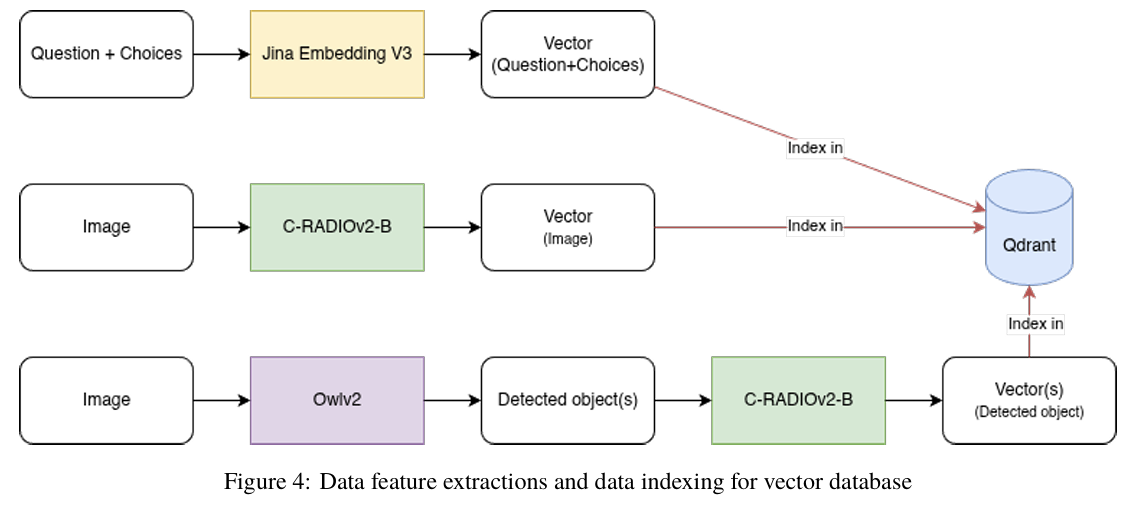

### 1.1.1. TextEmbedder (Jina Embeddings v3)

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"

class TextEmbedder:
    """
    Jina Embeddings v3
    Expected dim: 1024
    """
    def __init__(self, model_name="jinaai/jina-embeddings-v3"):
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, trust_remote_code=True
        )
        self.model = AutoModel.from_pretrained(
            model_name, trust_remote_code=True
        ).to(device)
        self.model.eval()

    @torch.no_grad()
    def embed(self, texts: list[str]) -> np.ndarray:
        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)

        outputs = self.model(**inputs)

        # Mean pooling (paper Berry baseline)
        emb = outputs.last_hidden_state.mean(dim=1)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)

        vec = emb.float().cpu().numpy()
        assert vec.shape[1] == 1024, f"Text emb dim = {vec.shape[1]} (expected 1024)"
        return vec


### 1.1.2. ImageEmbedder (C-RADIOv2-B)

In [ ]:
!pip install -q open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from transformers import AutoModel, CLIPImageProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

class ImageEmbedder:
    def __init__(self, model_name="nvidia/C-RADIOv2-B"):
        self.processor = CLIPImageProcessor.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True
        ).to(device)
        self.model.eval()

        # Lấy min step từ model
        self.min_step = getattr(self.model, 'min_resolution_step', 16)

    def _get_nearest_resolution(self, h, w):
        """Round to nearest multiple of min_step"""
        h_new = (h // self.min_step) * self.min_step
        w_new = (w // self.min_step) * self.min_step
        return h_new, w_new

    @torch.no_grad()
    def embed(self, images):
        # Resize về nearest supported resolution
        if len(images) > 0:
            h, w = images[0].size[1], images[0].size[0]  # PIL: (W, H)
            h_new, w_new = self._get_nearest_resolution(h, w)

            inputs = self.processor(
                images=images,
                return_tensors="pt",
                do_resize=True,
                size={"height": h_new, "width": w_new}
            )
        else:
            inputs = self.processor(
                images=images,
                return_tensors="pt",
                do_resize=True
            )

        pixel_values = inputs.pixel_values.to(device)

        summary, features = self.model(pixel_values)
        feats = torch.nn.functional.normalize(summary, dim=1)

        vec = feats.float().cpu().numpy()
        assert vec.shape[1] == 2304, vec.shape
        return vec

### 1.1.3. ObjectDetector (OWLv2)

In [ ]:
from transformers import Owlv2Processor, Owlv2ForObjectDetection

class OWLv2Detector:
    """
    OWLv2 object detector
    Paper Berry: discard objects < 32x32
    """
    def __init__(self, model_name="google/owlv2-base-patch16"):
        self.processor = Owlv2Processor.from_pretrained(model_name)
        self.model = Owlv2ForObjectDetection.from_pretrained(model_name).to(device)
        self.model.eval()

    @torch.no_grad()
    def detect(
        self,
        image,
        prompts: list[str],
        score_thr: float = 0.1,
        min_size: int = 32
    ) -> list:
        prompts = _ensure_flat_prompts(prompts)

        # DEBUG 1 LẦN CHO CHẮC
        assert isinstance(prompts, list)
        assert isinstance(prompts[0], str), prompts

        inputs = self.processor(
            text=prompts,
            images=image,
            return_tensors="pt"
        ).to(device)

        outputs = self.model(**inputs)

        target_sizes = torch.tensor(
            [image.size[::-1]], device=device
        )

        results = self.processor.post_process_object_detection(
            outputs,
            threshold=score_thr,
            target_sizes=target_sizes
        )[0]

        crops = []
        for box in results["boxes"]:
            x1, y1, x2, y2 = map(int, box.tolist())
            if (x2 - x1) < min_size or (y2 - y1) < min_size:
                continue
            crop = image.crop((x1, y1, x2, y2))
            crops.append(crop)

        return crops

### 1.1.4. Feature Extraction cho 1 sample train (CORE SUBTASK 1)

In [ ]:
from PIL import Image
import numpy as np

def extract_features_for_sample(
    sample: dict,
    image_dir: str,
    text_embedder: TextEmbedder,
    image_embedder: ImageEmbedder,
    detector: OWLv2Detector
) -> dict:
    """
    Extract full features for ONE training sample (Berry-style)
    """
    # ---- load image ----
    image_id = sample["image_id"]
    img_path = f"{image_dir}/{image_id}.jpg"
    img = Image.open(img_path).convert("RGB")

    # ---- TEXT ----
    text_input = build_text_input(sample)
    text_vec = text_embedder.embed([text_input])[0]

    # ---- IMAGE ----
    image_vec = image_embedder.embed([img])[0]

    # ---- OBJECTS ----
    crops = detector.detect(
        img,
        # prompts=["traffic sign", "road sign"]
        prompts = [
          "traffic sign",
          "road traffic sign",

          # Shape-based (RẤT QUAN TRỌNG)
          "circular traffic sign",
          "triangular traffic sign",
          "rectangular traffic sign",
          "square traffic sign",
          "octagonal traffic sign",

          # Specific iconic sign
          "stop sign",
        ]
    )

    # ---- FILTER small objects (Berry rule: >= 32x32) ----
    filtered_crops = [
        crop for crop in crops
        if crop.size[0] >= 32 and crop.size[1] >= 32
    ]

    # ---- EMBED OBJECTS ----
    if len(filtered_crops) == 0:
        object_vecs = np.zeros((0, 2304), dtype=np.float32)
    else:
        object_vecs = image_embedder.embed(filtered_crops)

    return {
        "id": sample["id"],
        "image_id": image_id,
        "text_embedding": text_vec,
        "image_embedding": image_vec,
        "object_embeddings": object_vecs,
        "relevant_articles": sample["relevant_articles"],
        "answer": sample["answer"],
        "question_type": sample["question_type"],
        "question": sample["question"],
        "choices": sample.get("choices"),
    }

#### *Test nhanh 1 sample*

In [ ]:
# import warnings
# warnings.filterwarnings(
#     "ignore",
#     message=".*flash_attn is not installed.*"
# )

In [ ]:
text_embedder = TextEmbedder()
image_embedder = ImageEmbedder()
detector = OWLv2Detector()

feat = extract_features_for_sample(
    train_data[0],
    TRAIN_IMAGE_DIR,
    text_embedder,
    image_embedder,
    detector
)

print("Text:", feat["text_embedding"].shape)
print("Image:", feat["image_embedding"].shape)
print("Objects:", feat["object_embeddings"].shape)
print("Articles:", feat["relevant_articles"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_xlm_roberta.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `dtype` instead!


modeling_lora.py: 0.00B [00:00, ?B/s]

modeling_xlm_roberta.py: 0.00B [00:00, ?B/s]

block.py: 0.00B [00:00, ?B/s]

stochastic_depth.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mlp.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mha.py: 0.00B [00:00, ?B/s]

rotary.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- stochastic_depth.py
- mlp.py
- mha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


embedding.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- block.py
- xlm_padding.py
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_lora.py
- modeling_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

hf_model.py: 0.00B [00:00, ?B/s]

feature_normalizer.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- feature_normalizer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


cls_token.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- cls_token.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


adaptor_mlp.py: 0.00B [00:00, ?B/s]

enable_spectral_reparam.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- enable_spectral_reparam.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- adaptor_mlp.py
- enable_spectral_reparam.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vit_patch_generator.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- vit_patch_generator.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


input_conditioner.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- input_conditioner.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


forward_intermediates.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- forward_intermediates.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


extra_timm_models.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- extra_timm_models.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


adaptor_registry.py: 0.00B [00:00, ?B/s]

adaptor_generic.py: 0.00B [00:00, ?B/s]

adaptor_base.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- adaptor_base.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- adaptor_generic.py
- adaptor_base.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- adaptor_registry.py
- adaptor_generic.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


radio_model.py: 0.00B [00:00, ?B/s]

enable_cpe_support.py: 0.00B [00:00, ?B/s]

dual_hybrid_vit.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- dual_hybrid_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


extra_models.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- extra_models.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- enable_cpe_support.py
- dual_hybrid_vit.py
- extra_models.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- radio_model.py
- enable_cpe_support.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


common.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- common.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


eradio_model.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- eradio_model.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


dinov2_arch.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- dinov2_arch.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vitdet.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- vitdet.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


open_clip_adaptor.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- open_clip_adaptor.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nvidia/C-RADIOv2-B:
- hf_model.py
- feature_normalizer.py
- cls_token.py
- adaptor_mlp.py
- vit_patch_generator.py
- input_conditioner.py
- forward_intermediates.py
- extra_timm_models.py
- adaptor_registry.py
- radio_model.py
- common.py
- eradio_model.py
- dinov2_arch.py
- vitdet.py
- open_clip_adaptor.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importi

model.safetensors:   0%|          | 0.00/393M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/620M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/owlv2/processing_owlv2.py:201: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


Text: (1024,)
Image: (2304,)
Objects: (9, 2304)
Articles: [{'law_id': 'QCVN 41:2024/BGTVT', 'article_id': '22'}]


In [ ]:
feat

{'id': 'train_1',
 'image_id': 'train_1_3',
 'text_embedding': array([-0.00063324, -0.10693359,  0.03662109, ..., -0.00022888,
        -0.00457764,  0.02050781], dtype=float32),
 'image_embedding': array([-0.0263199 ,  0.00436544, -0.02478387, ..., -0.00636368,
         0.00128584, -0.00560769], dtype=float32),
 'object_embeddings': array([[-0.02361527,  0.00528519, -0.02942372, ..., -0.01397286,
         -0.00060263,  0.00563261],
        [-0.02994315,  0.00459372, -0.03434925, ..., -0.00739922,
         -0.00600445, -0.00859173],
        [-0.02379627, -0.00191087, -0.0260106 , ...,  0.00018241,
         -0.01907139,  0.00926358],
        ...,
        [-0.00889078,  0.00886382, -0.02573278, ...,  0.01626734,
          0.00820784,  0.00757808],
        [-0.00385724, -0.0049993 , -0.03001549, ...,  0.03374719,
         -0.00633195, -0.00791474],
        [-0.00818453,  0.0033729 , -0.02413053, ...,  0.00750468,
          0.01243831,  0.00087755]], dtype=float32),
 'relevant_articles': [{

### 1.1.4. Tạo collection Qdrant

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import (
    VectorParams,
    Distance,
    HnswConfigDiff,
    MultiVectorConfig,
    MultiVectorComparator,
)

client = QdrantClient(
    url=QDRANT_URL,
    api_key=QDRANT_API_KEY,
    timeout=60,
)

if not client.collection_exists(COLLECTION_NAME):
    print(f"Creating collection `{COLLECTION_NAME}`...")
    client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config={
            "text_vector": VectorParams(
                size=1024,
                distance=Distance.COSINE,
                hnsw_config=HnswConfigDiff(m=16, ef_construct=200),
            ),
            "image_vector": VectorParams(
                size=2304,
                distance=Distance.COSINE,
                hnsw_config=HnswConfigDiff(m=16, ef_construct=200),
            ),
            "object_vectors": VectorParams(
                size=2304,
                distance=Distance.COSINE,
                hnsw_config=None,  # đúng
                multivector_config=MultiVectorConfig(
                    comparator=MultiVectorComparator.MAX_SIM
                ),
            ),
        },
    )
else:
    print(f"Collection `{COLLECTION_NAME}` already exists. Using it.")

Creating collection `mlqa_tsr_train_v2`...


In [ ]:
info = client.get_collection(COLLECTION_NAME)
print(info)

status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> warnings=None indexed_vectors_count=0 points_count=0 segments_count=2 config=CollectionConfig(params=CollectionParams(vectors={'image_vector': VectorParams(size=2304, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=HnswConfigDiff(m=16, ef_construct=200, full_scan_threshold=None, max_indexing_threads=None, on_disk=None, payload_m=None, inline_storage=None), quantization_config=None, on_disk=None, datatype=None, multivector_config=None), 'object_vectors': VectorParams(size=2304, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)), 'text_vector': VectorParams(size=1024, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=HnswConfigDiff(m=16, ef_construct=200, full_scan_threshold=None, max_indexing_threads=None, on_disk=None, payload_m=None, inline_st

### 1.1.5. Upsert training data vào Qdrant

In [ ]:
from qdrant_client import models

def upsert_sample(
    client,
    collection_name,
    sample,
    image_dir,
    text_embedder,
    image_embedder,
    owlv2_detector,
    idx=None,
    total=None,
):
    """Upsert 1 sample vào Qdrant với deterministic UUID"""

    image_id = sample["image_id"]
    img_path = f"{image_dir}/{image_id}.jpg"
    img = Image.open(img_path).convert("RGB")

    # -------- Text embedding --------
    question_text = sample["question"]

    if "choices" in sample and sample["choices"]:
        text_query = question_text + "\n" + format_choices(sample["choices"])
    else:
        text_query = question_text

    text_vec = text_embedder.embed([text_query])[0]

    # -------- Image embedding --------
    img_vec = image_embedder.embed([img])[0]

    # -------- Object detection --------
    crops = owlv2_detector.detect(
        image=img,
        # prompts=["object", "thing", "item"],
        prompts = [
          "traffic sign",
          "road traffic sign",

          # Shape-based (RẤT QUAN TRỌNG)
          "circular traffic sign",
          "triangular traffic sign",
          "rectangular traffic sign",
          "square traffic sign",
          "octagonal traffic sign",

          # Specific iconic sign
          "stop sign",
        ],
        score_thr=0.1,
        min_size=32
    )

    # -------- Vector dict --------
    text_vec_list = text_vec.tolist() if hasattr(text_vec, "tolist") else text_vec
    img_vec_list = img_vec.tolist() if hasattr(img_vec, "tolist") else img_vec

    vector_dict = {
        "text_vector": text_vec_list,
        "image_vector": img_vec_list,
    }

    if crops:
        obj_vecs = image_embedder.embed(crops)
        vector_dict["object_vectors"] = [
            v.tolist() if hasattr(v, "tolist") else v for v in obj_vecs
        ]
    else:
        vector_dict["object_vectors"] = [img_vec_list]

    point = models.PointStruct(
        id=sample_id_to_uuid(sample["id"]),
        vector=vector_dict,
        payload={
            "sample_id": sample["id"],
            "question": sample["question"],
            "choices": sample.get("choices", {}),
            "answer": sample["answer"],
            "question_type": sample.get("question_type", "Unknown"),
            "relevant_articles": sample.get("relevant_articles", []),
            "has_objects": len(crops) > 0,
        },
    )

    client.upsert(collection_name=collection_name, points=[point])

    # -------- Progress log --------
    if idx is not None and total is not None:
        print(
            f"[{idx:4d}/{total}] "
            f"Upserted {sample['id']} | "
            f"type={sample.get('question_type')} | "
            f"objects={len(crops)}"
        )


#### !!!!! **Upsert full data**

In [ ]:
from tqdm import tqdm
for sample in tqdm(train_data, desc="Upserting samples", total=len(train_data)):
    upsert_sample(
        client,
        COLLECTION_NAME,
        sample,
        TRAIN_IMAGE_DIR,
        text_embedder,
        image_embedder,
        detector,
    )

Upserting samples: 100%|██████████| 530/530 [19:13<00:00,  2.18s/it]


In [ ]:
# feat

In [ ]:
# Kiểm tra số vector trong collection
info = client.get_collection(COLLECTION_NAME)
print(info.points_count)

530


In [ ]:
# Kiểm tra xem có nhữn g vector name nào
from pprint import pprint
pprint(info.config.params.vectors)

{'image_vector': VectorParams(size=2304, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=HnswConfigDiff(m=16, ef_construct=200, full_scan_threshold=None, max_indexing_threads=None, on_disk=None, payload_m=None, inline_storage=None), quantization_config=None, on_disk=None, datatype=None, multivector_config=None),
 'object_vectors': VectorParams(size=2304, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)),
 'text_vector': VectorParams(size=1024, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=HnswConfigDiff(m=16, ef_construct=200, full_scan_threshold=None, max_indexing_threads=None, on_disk=None, payload_m=None, inline_storage=None), quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}


## **1.2 Retrieval pipeline (Berry-style)**

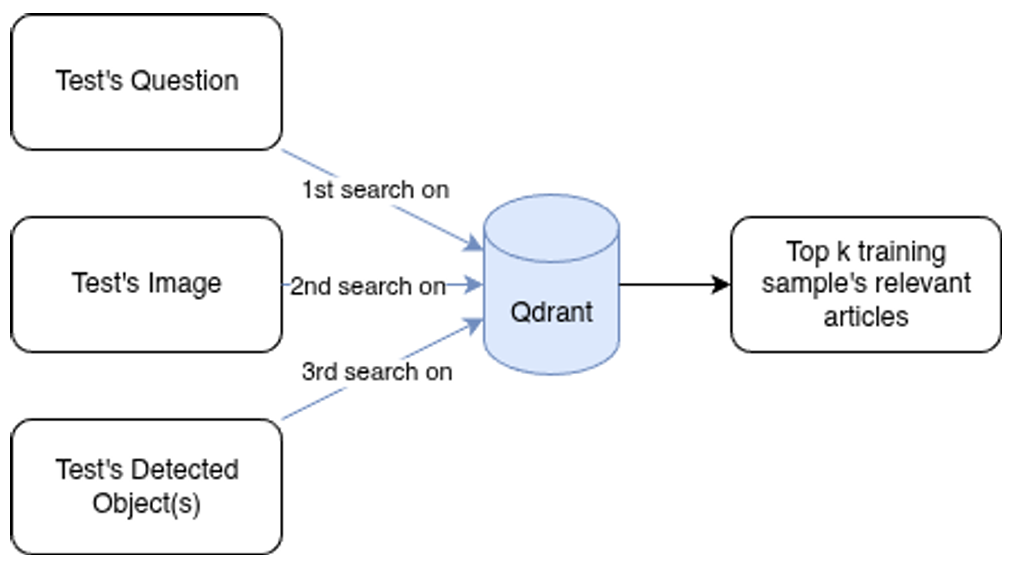

### 1.2.1. Viết retrieve_similar_samples()

In [ ]:
from collections import defaultdict

def retrieve_similar_samples(
    question: str,
    choices: dict,
    image_pil,
    qdrant_client,
    collection_name: str,
    text_embedder,
    image_embedder,
    owlv2_detector,
    n: int = 10,
    m: int = 5,
    k: int = 3,
):
    """Berry-style 3-stage retrieval"""
    assert k <= m <= n, "Berry constraint: k <= m <= n"

    # Stage 1: Text
    if choices and len(choices) > 0:
        text_query = question.strip() + "\n" + format_choices(choices)
    else:
        text_query = question.strip()

    text_vec = text_embedder.embed([text_query])[0]
    top_n_points = qdrant_client.query_points(
        collection_name=collection_name,
        query=text_vec,
        using="text_vector",
        limit=n,
        with_payload=True,
    ).points

    if not top_n_points:
        return []

    # Stage 2: Image
    img_vec = image_embedder.embed([image_pil])[0]
    top_m_points = qdrant_client.query_points(
        collection_name=collection_name,
        query=img_vec.tolist(),
        using="image_vector",
        limit=m,
        query_filter=make_ids_filter(top_n_points),
        with_payload=True,
    ).points

    if not top_m_points:
        #  FIX: Keep text scores
        return [(p, p.score) for p in top_n_points[:k]]

    # Stage 3: Objects
    # prompts = ["traffic sign", "road sign", "sign"]  # Simplified
    prompts = [
      "traffic sign",
      "road traffic sign",

      # Shape-based (RẤT QUAN TRỌNG)
      "circular traffic sign",
      "triangular traffic sign",
      "rectangular traffic sign",
      "square traffic sign",
      "octagonal traffic sign",

      # Specific iconic sign
      "stop sign",
    ]

    crops = owlv2_detector.detect(
        image=image_pil,
        prompts=prompts,
        score_thr=0.1,
        min_size=32,
    )

    valid_crops = [c for c in crops if c.size[0] >= 32 and c.size[1] >= 32]

    if not valid_crops:
        #  FIX: Keep image scores
        return [(p, p.score) for p in top_m_points[:k]]

    obj_vecs = image_embedder.embed(valid_crops)
    top_m_filter = make_ids_filter(top_m_points)
    maxsim_scores = defaultdict(float)

    for obj_vec in obj_vecs:
        results = qdrant_client.query_points(
            collection_name=collection_name,
            query=obj_vec.tolist(),
            using="object_vectors",
            limit=m,
            query_filter=top_m_filter,
            with_payload=True,
        ).points

        for p in results:
            maxsim_scores[p.id] = max(maxsim_scores[p.id], p.score)

    if not maxsim_scores:
        # FIX: Keep image scores
        return [(p, p.score) for p in top_m_points[:k]]

    # Final ranking
    ranked = sorted(maxsim_scores.items(), key=lambda x: x[1], reverse=True)[:k]
    top_k_ids = [pid for pid, _ in ranked]
    top_k_points = qdrant_client.retrieve(
        collection_name=collection_name,
        ids=top_k_ids,
        with_payload=True,
    )

    id2score = dict(ranked)
    top_k_points.sort(key=lambda p: id2score[p.id], reverse=True)

    return [(p, id2score[p.id]) for p in top_k_points]

### 1.2.2. Test retrieval => Top-K Training Samples gần nhất

In [ ]:
import os
import pickle
from tqdm import tqdm
from PIL import Image


def run_retrieval(dataset):
    """
    Run Subtask 1 retrieval.
    - Resume nếu đã có pkl
    - Chỉ SAVE 1 LẦN DUY NHẤT (an toàn với Google Drive)
    """

    # --------------------------------------------------
    # Resume
    if os.path.exists(RETRIEVAL_PATH):
        with open(RETRIEVAL_PATH, "rb") as f:
            all_results = pickle.load(f)
        print(f"[Resume] Loaded {len(all_results)} samples")
    else:
        all_results = {}

    total = len(dataset)

    # --------------------------------------------------
    # Retrieval loop
    for i, sample in enumerate(
        tqdm(dataset, total=total, desc="Retrieval"), start=1
    ):
        sid = sample["id"]

        # ---- Skip if already done ----
        if sid in all_results:
            tqdm.write(f"[Skip] {i}/{total} - {sid}")
            continue

        image_path = TEST_IMAGE_DIR / f"{sample['image_id']}.jpg"
        image_pil = Image.open(image_path).convert("RGB")

        retrieved = retrieve_similar_samples(
            question=sample["question"],
            choices=sample.get("choices", {}),
            image_pil=image_pil,
            qdrant_client=client,
            collection_name=COLLECTION_NAME,
            text_embedder=text_embedder,
            image_embedder=image_embedder,
            owlv2_detector=detector,
            n=N_TEXTS,
            m=M_IMGS,
            k=K_OBJS,
        )

        all_results[sid] = retrieved

    # --------------------------------------------------
    # SAVE ONCE (IMPORTANT)
    with open(RETRIEVAL_PATH, "wb") as f:
        pickle.dump(all_results, f)

    print(f"[Saved] {len(all_results)} samples → {RETRIEVAL_PATH}")
    return all_results


In [ ]:
test_dataset = test_data
all_results = run_retrieval(test_dataset)

Retrieval: 100%|██████████| 100/100 [06:06<00:00,  3.67s/it]

[Saved] 100 samples → /content/drive/MyDrive/MLQA-TSR/BERRY/outputs/20251225-fulldata/subtask1_retrieval_n10_m5_k3_v2.pkl


### 1.2.3. Debug check

In [ ]:
def pretty_check_sample(sample, retrieved):
    print("=" * 70)
    print("QUESTION ID:", sample["id"])
    print("QUESTION:")
    print(sample["question"])
    print()

    # ----- Ground truth -----
    print("GROUND TRUTH ARTICLES:")
    gt_articles = set()
    for a in sample["relevant_articles"]:
        gt_articles.add((a["law_id"], a["article_id"]))
        print(f"  - {a['law_id']} | {a['article_id']}")

    # ----- Retrieved samples -----
    print("\nRETRIEVED TRAINING SAMPLES:")
    for i, (r, score) in enumerate(retrieved, 1):
        print(f"\n  [{i}] MaxSim = {score:.4f}")
        print("   Sample ID:", r.payload["sample_id"])
        print("   Question:", r.payload["question"])
        print("   Articles:")
        for art in r.payload["relevant_articles"]:
            print(f"     • {art['law_id']} | {art['article_id']}")

    # ----- Extracted articles -----
    pred_articles = extract_articles_from_results(retrieved)

    print("\nEXTRACTED ARTICLES:")
    for law_id, article_id in pred_articles:
        mark = "✅" if (law_id, article_id) in gt_articles else "❌"
        print(f"  {mark} {law_id} | {article_id}")

    print("\nSUMMARY:")
    print("  #GT articles:", len(gt_articles))
    print("  #Pred articles:", len(pred_articles))
    print("  #Correct:", len(gt_articles & pred_articles))
    print("=" * 70)


In [ ]:
def debug_retrieval(dataset, all_results, limit=3):
    for sample in dataset[:limit]:
        pretty_check_sample(
            sample,
            all_results[sample["id"]]
        )

*Chạy retrieval*

In [ ]:
debug_retrieval(test_dataset, all_results)

QUESTION ID: public_test_1
QUESTION:
Đây là biển báo gì?

GROUND TRUTH ARTICLES:
  - QCVN 41:2024/BGTVT | 22
  - QCVN 41:2024/BGTVT | B.31

RETRIEVED TRAINING SAMPLES:

  [1] MaxSim = 1.0000
   Sample ID: train_118
   Question: Đây là biển báo gì?
   Articles:
     • QCVN 41:2024/BGTVT | 22
     • QCVN 41:2024/BGTVT | B.31

  [2] MaxSim = 0.6412
   Sample ID: train_89
   Question: Đây là biển báo gì? 
   Articles:
     • QCVN 41:2024/BGTVT | 22
     • QCVN 41:2024/BGTVT | B.30

  [3] MaxSim = 0.5833
   Sample ID: train_497
   Question: Biển báo này là biển báo cấm đỗ và dừng xe là đúng hay sai
   Articles:
     • QCVN 41:2024/BGTVT | 22
     • QCVN 41:2024/BGTVT | B.31

EXTRACTED ARTICLES:
  ✅ QCVN 41:2024/BGTVT | B.31
  ❌ QCVN 41:2024/BGTVT | B.30
  ✅ QCVN 41:2024/BGTVT | 22

SUMMARY:
  #GT articles: 2
  #Pred articles: 3
  #Correct: 2
QUESTION ID: public_test_2
QUESTION:
Biển báo màu xanh có gạch đỏ là biển báo gì?

GROUND TRUTH ARTICLES:
  - QCVN 41:2024/BGTVT | 22
  - QCVN 41:2024/

## **1.3. Evaluate Subtask 1**

In [ ]:
def compute_metrics_single(gt_articles, pred_articles):
    """Compute precision, recall, F2 for single sample"""

    # Edge cases
    if len(gt_articles) == 0 and len(pred_articles) == 0:
        return {"precision": 1.0, "recall": 1.0, "f2": 1.0, "correct": 0}

    if len(gt_articles) == 0:
        return {"precision": 0.0, "recall": 1.0, "f2": 0.0, "correct": 0}

    if len(pred_articles) == 0:
        return {"precision": 0.0, "recall": 0.0, "f2": 0.0, "correct": 0}

    correct = len(gt_articles & pred_articles)
    precision = correct / len(pred_articles)
    recall = correct / len(gt_articles)

    if precision + recall == 0:
        f2 = 0.0
    else:
        f2 = 5 * precision * recall / (4 * precision + recall)

    return {
        "precision": precision,
        "recall": recall,
        "f2": f2,
        "correct": correct
    }


In [ ]:
def evaluate_subtask1_multi_k(dataset, all_results, max_articles_list=(1, 2, 3)):
    """
    Evaluate Subtask 1 for multiple max_articles values
    """

    results = {}

    for k in max_articles_list:
        all_precision = []
        all_recall = []
        all_f2 = []

        for sample in dataset:
            sample_id = sample["id"]

            gt = {
                (a["law_id"], a["article_id"])
                for a in sample["relevant_articles"]
            }

            pred = extract_articles_from_results(
                all_results[sample_id],
                max_articles=k
            )

            metrics = compute_metrics_single(gt, pred)

            all_precision.append(metrics["precision"])
            all_recall.append(metrics["recall"])
            all_f2.append(metrics["f2"])

        results[k] = {
            "precision": sum(all_precision) / len(all_precision),
            "recall": sum(all_recall) / len(all_recall),
            "f2": sum(all_f2) / len(all_f2),
        }

    return results


In [ ]:
def save_subtask1_eval_txt(metrics_by_k, save_path, extra_info=None):
    """
    metrics_by_k: dict[k] -> {precision, recall, f2}
    save_path: path to .txt file
    extra_info: optional dict (config info)
    """
    with open(save_path, "w") as f:
        f.write("Subtask 1 Evaluation (by max_articles)\n")
        f.write("=====================================\n")

        if extra_info is not None:
            f.write("\n[Config]\n")
            for k, v in extra_info.items():
                f.write(f"{k}: {v}\n")

        for k, m in metrics_by_k.items():
            f.write(f"\nmax_articles = {k}\n")
            f.write(f"  Precision: {m['precision']:.4f}\n")
            f.write(f"  Recall:    {m['recall']:.4f}\n")
            f.write(f"  F2-score:  {m['f2']:.4f}\n")


*Chạy evaluate subtask 1*

In [ ]:
metrics_by_k = evaluate_subtask1_multi_k(
    test_dataset,
    all_results,
    max_articles_list=[1, 2, 3, 4, 5]
)

save_subtask1_eval_txt(
    metrics_by_k,
    EVAL_PATH,
    extra_info={
        "dataset": f"{len(test_data)}",
        "n": 10,
        "m": 5,
        "retrieval_k": 3,
    }
)

print("Saved evaluation to:", EVAL_PATH)

print("\nSubtask 1 Evaluation (by max_articles)")
print("=====================================")

for k, m in metrics_by_k.items():
    print(f"\nmax_articles = {k}")
    print(f"  Precision: {m['precision']:.4f}")
    print(f"  Recall:    {m['recall']:.4f}")
    print(f"  F2-score:  {m['f2']:.4f}")


Saved evaluation to: /content/drive/MyDrive/MLQA-TSR/BERRY/outputs/20251225-fulldata/subtask1_eval_n10_m5_k3_v2.txt

Subtask 1 Evaluation (by max_articles)

max_articles = 1
  Precision: 0.4694
  Recall:    0.4931
  F2-score:  0.4786

max_articles = 2
  Precision: 0.3665
  Recall:    0.5831
  F2-score:  0.5050

max_articles = 3
  Precision: 0.3111
  Recall:    0.6439
  F2-score:  0.5117

max_articles = 4
  Precision: 0.3111
  Recall:    0.6439
  F2-score:  0.5117

max_articles = 5
  Precision: 0.3111
  Recall:    0.6439
  F2-score:  0.5117
